# Exploration of Data and Preprocessing

This dataset was taken from Kaggle: https://www.kaggle.com/datasets/datasnaek/mbti-type.
It includes over 8600 rows of data, with each row having a person's MBTI type and their top 50 posts.

**Exploring the Data:**

Before preprocessing the data, we first explore what it looks like, including the number of tweets per personality type and what the tweets actually look like.

In [11]:
import pandas as pd

data = pd.read_csv('data/mbti_1.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [12]:
# looks at general data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [13]:
# counts number of tweets per MBTI type
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [14]:
# look at some of the tweets directly
print("Type: {} \nPosts: {}".format(data.type[0], data.posts[0]))

Type: INFJ 
Posts: 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-h

There seem to be some tweets we need to parse out, including symbols and hyperlinks. We want to look at the words in these tweets, so the hyperlinks and symbols will not be factored into our classification.

We can also look at the distribution between each personality type indicator.

In [15]:
import numpy as np
b_dict = {'I': 0, 'E': 1, 'N': 0, 'S': 1, 'F': 0, 'T': 1, 'J': 0, 'P': 1}
def binarize_indicators(data):
    binarized_type = []
    for type in data.type:
        binarized_type.append([b_dict[letter] for letter in type])
    return np.array(binarized_type)

b_types = binarize_indicators(data)
df_types = pd.DataFrame(b_types, columns=['IE', 'NS', 'FT', 'JP'])
data = data.join(df_types)
data.head()


,type,posts,IE,NS,FT,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0


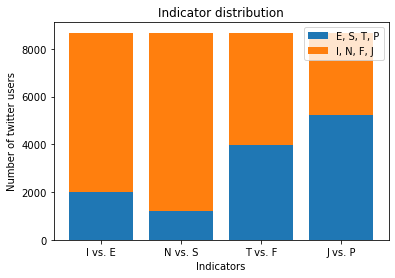

In [16]:
import matplotlib.pyplot as plt
# visualization of distribution
total_num = data.shape[0]

num_E = data['IE'].sum()
num_S = data['NS'].sum()
num_T = data['FT'].sum()
num_P = data['JP'].sum()

lower_half = (num_E, num_S, num_T, num_P)
upper_half = (total_num - num_E, total_num - num_S, total_num - num_T, total_num - num_P)
x_loc = np.arange(4)

p1 = plt.bar(x_loc, lower_half, label='E, S, T, P')
p2 = plt.bar(x_loc, upper_half, bottom=lower_half, label='I, N, F, J')

plt.title('Indicator distribution')
plt.ylabel('Number of twitter users')
plt.xlabel('Indicators')
plt.xticks(x_loc, ('I vs. E',  'N vs. S', 'T vs. F', 'J vs. P',))
plt.legend()
plt.show()

## Preprocessing the data:

First, we clean the data. Because there are symbols, hyperlinks, and stopwords we would like to get rid of, we will start by taking out these words/phrases. 

In [17]:
import re
import string

# Helper function: get rid of |||, hyperlinks, symbols, parentheses, punctuation, etc.
def clean_data(data):
    cleaned_data = []

    for tweets in data.posts:
        # get rid of '|||' inbetween the tweets
        tweets = re.sub(r'\|', ' ', tweets)
        # hyperlinks
        tweets = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ', tweets)
        # punctuation
        tweets = re.sub(r'['+re.escape(string.punctuation)+']', ' ', tweets)
        tweets = re.sub(r'[’‘“\.”…–]', ' ', tweets)
        # gets rid of brackets
        tweets = re.sub(r'(\[|\()*\d+(\]|\))*', ' ', tweets)
        # gets rid of large spaces
        tweets = re.sub(r' +', ' ', tweets)

        cleaned_data.append(tweets.lower())

    return cleaned_data

In [18]:
# clean
data['cleaned_data'] = clean_data(data)

After cleaning the data, we can see which types of words are most popular in each MBTI personality type's twitter tweets.

In [19]:
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

def wordclouds(df):
    fig, ax = plt.subplots(len(df['type'].unique()), sharex=True, figsize=(20,len(df['type'].unique())))
    num = 0
    for type in df['type'].unique():
        df_4 = df[df['type'] == type]
        wordcloud = WordCloud(max_words=50, relative_scaling=1).generate(df_4['cleaned_data'].to_string())
        
        plt.subplot(4, 4, num + 1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(type)
        ax[num].axis("off")
        num += 1

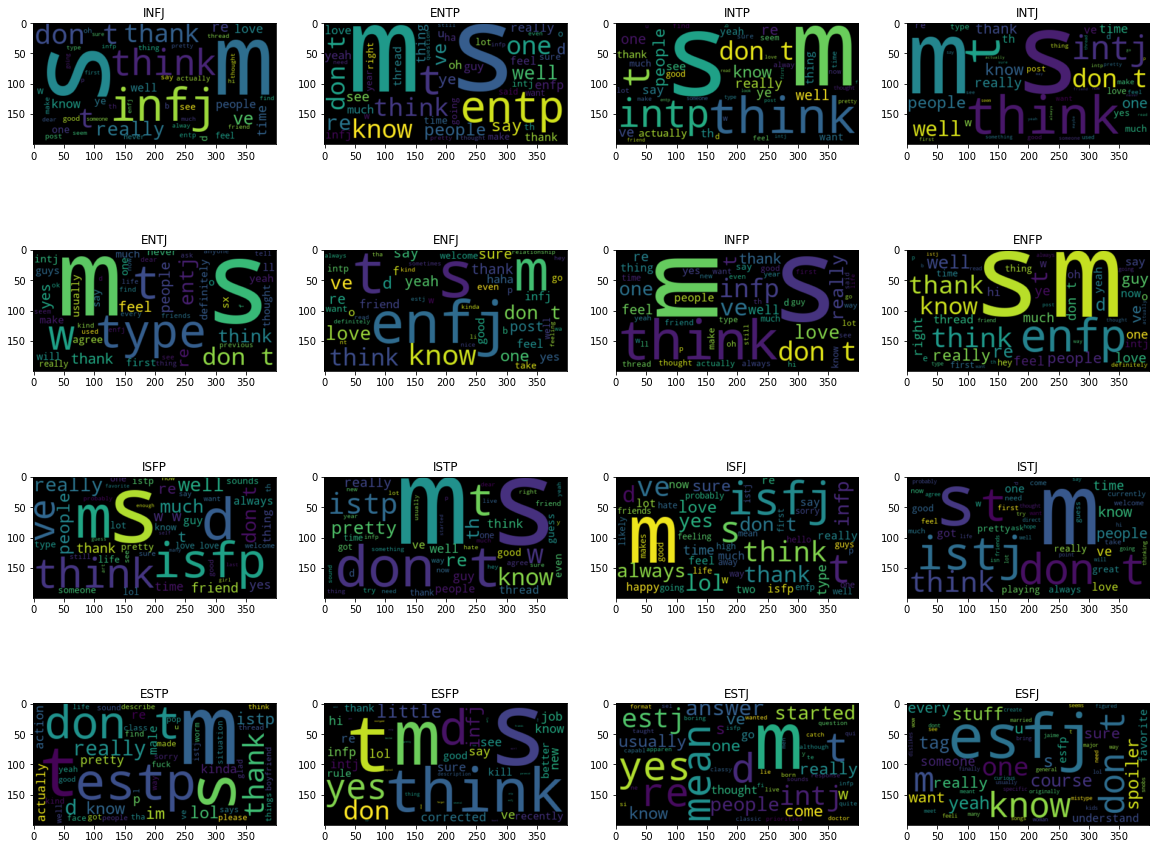

In [20]:
wordclouds(data)

Now, we lemmatize the data and use tf-idf weighting to see which words are weighted more heavily with each user.

In [21]:
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download stopwords list
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# create stopwords list
stop_words = set(stopwords.words('english')) 

# combine nltk with sklearn 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(token) for token in word_tokenize(doc)]

[nltk_data] Downloading package stopwords to /Users/jmc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jmc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jmc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jmc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Lemmatize the stop words, lowercase
tokenizer = LemmaTokenizer()
tfidf_vectorizer = TfidfVectorizer(stop_words=tokenizer(' '.join(stop_words)), lowercase=True, tokenizer=tokenizer, max_features=10000, min_df = .01)

In [38]:
# Get vocabulary
corpus_count = tfidf_vectorizer.fit_transform(data.cleaned_data)
vocab = tfidf_vectorizer.vocabulary_

In [29]:
# Split data into train and test data
from sklearn.model_selection import train_test_split

# split the data into training and test data: 80:20
train_data, test_data = train_test_split(data, test_size=.2)

In [40]:
tfidf_vectorizer = TfidfVectorizer(stop_words=tokenizer(' '.join(stop_words)), lowercase=True, tokenizer=tokenizer, max_features=10000, min_df = .01, vocabulary=vocab)

In [41]:
tfidf_train_posts = tfidf_vectorizer.fit_transform(train_data.cleaned_data).toarray()
# tfidf_train_posts = tfidf_vectorizer.transform(train_data.cleaned_data)

In [42]:
train_tokens = tfidf_vectorizer.get_feature_names()
tfidf_df_train = pd.DataFrame(data=tfidf_train_posts, index=train_data.type, columns=train_tokens)
tfidf_df_train

,abandon,abandoned,ability,able,abortion,abroad,absence,absent,absolute,absolutely,...,youre,youth,youtube,yr,yup,z,zero,zodiac,zombie,zone
type,,,,,,,,,,,,,,,,,,,,,
INTP,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
INTJ,0.0,0.0,0.040389,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
ENTP,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
ISTP,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.000000,0.040218,0.0,0.0,0.0,0.000000,0.000000
ENTP,0.0,0.0,0.000000,0.027295,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.058603,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENTP,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
INTP,0.0,0.0,0.000000,0.021876,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
ENTP,0.0,0.0,0.000000,0.028037,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.04467,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [43]:
tfidf_vectorizer.fit(test_data.cleaned_data)
tfidf_test_posts = tfidf_vectorizer.transform(test_data.cleaned_data).toarray()

/Users/jmc/opt/miniconda3/envs/cs229/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [44]:
test_tokens = tfidf_vectorizer.get_feature_names()
tfidf_df_test = pd.DataFrame(data=tfidf_test_posts, index=test_data.type, columns=test_tokens)
tfidf_df_test

,abandon,abandoned,ability,able,abortion,abroad,absence,absent,absolute,absolutely,...,youre,youth,youtube,yr,yup,z,zero,zodiac,zombie,zone
type,,,,,,,,,,,,,,,,,,,,,
ENTP,0.0,0.0,0.000000,0.026151,0.0,0.0,0.0,0.0,0.0,0.063578,...,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
ENFJ,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
ENFP,0.0,0.0,0.000000,0.046339,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.00000,0.042447,0.0,0.0,0.0,0.0,0.0
ESFP,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
INTP,0.0,0.0,0.000000,0.028721,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INTP,0.0,0.0,0.000000,0.023893,0.0,0.0,0.0,0.0,0.0,0.029044,...,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
INFP,0.0,0.0,0.000000,0.047558,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
ENFP,0.0,0.0,0.000000,0.020968,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0


Retrieve the binarized indicators for both training and test data (labels):

The second letter of each label is indicated by 1 (in "IE", I = 0 and E = 1)

In [45]:
b_train_types = train_data.iloc[:, 2:6].reset_index(drop = True)
b_test_types = test_data.iloc[:, 2:6].reset_index(drop = True)

print('Training indicator types: \n{}'.format(b_train_types.head()))
print('Test indicator types: \n{}'.format(b_test_types.head()))

Training indicator types: 
   IE  NS  FT  JP
0   0   0   1   1
1   0   0   1   0
2   1   0   1   1
3   0   1   1   1
4   1   0   1   1
Test indicator types: 
   IE  NS  FT  JP
0   1   0   1   1
1   1   0   0   0
2   1   0   0   1
3   1   1   0   1
4   0   0   1   1


Save the preprocessed, normalized data into a csv file:

In [46]:
# training data
compression_opts = dict(method='zip', archive_name='tfidf_train_data.csv')  
tfidf_df_train.to_csv('data/tfidf_train_data.zip', compression=compression_opts)

In [47]:
# test data
compression_opts = dict(method='zip', archive_name='tfidf_test_data.csv')  
tfidf_df_test.to_csv('data/tfidf_test_data.zip', compression=compression_opts)

In [48]:
# binarized training labels
compression_opts = dict(method='zip', archive_name='b_train_labels.csv')  
b_train_types.to_csv('data/b_train_labels.zip', compression=compression_opts)

In [49]:
# binarized test labels
compression_opts = dict(method='zip', archive_name='b_test_labels.csv')  
b_test_types.to_csv('data/b_test_labels.zip', compression=compression_opts)